In [64]:
from keras.layers import Dense, Dropout, LSTM
import numpy as np
#from MergeOnlyETHandBTCPrices import mergeDataframesPrices
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
import pandas as pd
import pytz
import matplotlib.pyplot as plt




In [45]:

berlin_tz = pytz.timezone('Europe/Berlin')

# TEST DATA NOT IN DATABASE YET - ETH-USD prices
dfPrices = pd.read_csv('../Abgabe/ETHUSD_1.csv')
dfPrices = dfPrices.dropna()
dfPrices.rename(columns={"1438956180": "Date", "3.0": "Open", "3.0.1": "High", "3.0.2": "Low", "3.0.3": "Close", "81.85727776": "Volume", "2": "Trades"}, inplace=True)
dfPrices['Date'] = pd.to_datetime(dfPrices['Date'], unit='s')
dfPrices['Date'] = pd.to_datetime(dfPrices['Date'], utc=True)
dfPrices['Date'] = dfPrices['Date'].dt.floor('T')
dfPrices['Date'] = dfPrices['Date'].dt.tz_convert(berlin_tz)

dfBtcPrices = pd.read_csv('../Abgabe/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
dfBtcPrices = dfBtcPrices.dropna()
dfBtcPrices['Timestamp'] = pd.to_datetime(dfBtcPrices['Timestamp'], unit='s')
dfBtcPrices['Timestamp'] = pd.to_datetime(dfBtcPrices['Timestamp'], utc=True)
dfBtcPrices['Timestamp'] = dfBtcPrices['Timestamp'].dt.floor('T')
dfBtcPrices['Timestamp'] = dfBtcPrices['Timestamp'].dt.tz_convert(berlin_tz)
dfBtcPrices.rename(columns={"Close": "BTC_Close"}, inplace=True)
dfBtcPrices = dfBtcPrices.dropna()
dfPrices['Date'] = dfPrices['Date'].dt.strftime('%Y-%m-%d %H:%M:%S')
dfBtcPrices['Timestamp'] = dfBtcPrices['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
merged_df = pd.merge(dfPrices, dfBtcPrices, left_on='Date', right_on='Timestamp')

df = merged_df
df = df.dropna()

# Adding technical indicators
df['RSI'] = ta.rsi(df.Close, length=15)
df['EMAF'] = ta.ema(df.Close, length=20)
df['EMAM'] = ta.ema(df.Close, length=100)
df['EMAS'] = ta.ema(df.Close, length=150)

df = df.dropna()
df['target'] = df['Close'].shift(-1)
print(df['target'], df['Close'])

# Drop string data and 'Timestamp' column
df.drop(['Date', 'Trades', 'Volume', 'Volume_(BTC)', 'Volume_(Currency)', 'Timestamp'  ], axis=1, inplace=True)

# Split the data into features and target variables
features = df.drop(['target'], axis=1)
target = df['target']

target = target.dropna()



df.head(10)
df.head(-5)

149           1.37445
150           1.23000
151           1.48500
152           1.48500
153           1.49486
              ...    
1734884    1841.69000
1734885    1841.63000
1734886    1841.69000
1734887    1842.74000
1734888           NaN
Name: target, Length: 1734740, dtype: float64 149           1.37445
150           1.37445
151           1.23000
152           1.48500
153           1.48500
              ...    
1734884    1842.04000
1734885    1841.69000
1734886    1841.63000
1734887    1841.69000
1734888    1842.74000
Name: Close, Length: 1734740, dtype: float64


,Open_x,High_x,Low_x,Close,Open_y,High_y,Low_y,BTC_Close,Weighted_Price,RSI,EMAF,EMAM,EMAS,target
149,1.37445,1.37445,1.37445,1.37445,257.04,257.04,257.00,257.00,257.000720,50.588359,1.300992,1.420629,1.409009,1.37445
150,1.37445,1.37445,1.37445,1.37445,257.39,257.39,257.39,257.39,257.390000,50.588359,1.307988,1.419714,1.408551,1.23000
151,1.23450,1.23450,1.23000,1.23000,257.39,257.39,257.33,257.33,257.340625,46.500526,1.300561,1.415958,1.406186,1.48500
152,1.48500,1.48500,1.48500,1.48500,258.75,259.05,258.73,258.73,258.779575,53.593200,1.318127,1.417325,1.407230,1.48500
153,1.48500,1.48500,1.48500,1.48500,259.20,259.21,259.20,259.21,259.204301,53.593200,1.334019,1.418665,1.408260,1.49486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734879,1840.46000,1840.51000,1839.87000,1839.92000,58699.45,58699.45,58675.12,58677.70,58677.332331,45.229429,1840.282966,1841.905250,1842.317558,1839.68000
1734880,1839.67000,1839.68000,1839.67000,1839.68000,58673.20,58673.20,58644.13,58644.13,58644.258412,43.785307,1840.225541,1841.861186,1842.282623,1840.72000
1734881,1840.37000,1840.72000,1840.37000,1840.72000,58673.20,58689.44,58673.20,58689.44,58677.435702,51.042772,1840.272632,1841.838588,1842.261926,1841.49000
1734882,1841.20000,1841.72000,1840.92000,1841.49000,58677.05,58699.90,58660.00,58699.90,58680.021260,55.590852,1840.388572,1841.831685,1842.251702,1841.60000


In [46]:
# Scaling the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

In [47]:
# Split the data into training and test sets
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train_features = scaled_features[:train_size]
train_target = target[:train_size]
test_features = scaled_features[train_size:]
test_target = target[train_size:]

In [48]:
# Reshape the training data into the required LSTM input format
x_train = np.reshape(train_features, (train_features.shape[0], train_features.shape[1], 1))
y_train = np.array(train_target)

In [49]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

2023-07-08 16:33:15.062955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-08 16:33:15.069970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-08 16:33:15.072095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [50]:
# Compile and train the LSTM model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=1, batch_size=70)

2023-07-08 16:33:30.140339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-08 16:33:30.144333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-08 16:33:30.146477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19826/19826 [==============================] - 880s 44ms/step - loss: 38997.6562


In [51]:
# Make predictions with the LSTM model
x_test = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
predicted_prices = model.predict(x_test)

2023-07-08 16:48:25.542601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-08 16:48:25.544948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-08 16:48:25.547921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10843/10843 [==============================] - 92s 8ms/step


In [60]:
# Reshape the predicted prices to match the original shape
predicted_prices = predicted_prices.reshape(predicted_prices.shape[1], features.shape[0])

ValueError: cannot reshape array of size 346948 into shape (1,1734740)

In [62]:
# Inverse scaling of the predictions
reshaped_predicted_prices = np.zeros((predicted_prices.shape[0], scaled_features.shape[1]))
reshaped_predicted_prices[:, -1] = predicted_prices[:, 0]
predicted_prices = scaler.inverse_transform(reshaped_predicted_prices)

In [63]:
# Output the predictions
print(predicted_prices)

[[4.11010000e-01 4.11010000e-01 4.11010000e-01 ... 4.52113959e-01
  5.48330793e-01 4.70576043e+05]
 [4.11010000e-01 4.11010000e-01 4.11010000e-01 ... 4.52113959e-01
  5.48330793e-01 4.70306716e+05]
 [4.11010000e-01 4.11010000e-01 4.11010000e-01 ... 4.52113959e-01
  5.48330793e-01 4.69817814e+05]
 ...
 [4.11010000e-01 4.11010000e-01 4.11010000e-01 ... 4.52113959e-01
  5.48330793e-01 1.60521168e+06]
 [4.11010000e-01 4.11010000e-01 4.11010000e-01 ... 4.52113959e-01
  5.48330793e-01 1.60521168e+06]
 [4.11010000e-01 4.11010000e-01 4.11010000e-01 ... 4.52113959e-01
  5.48330793e-01 1.60521168e+06]]


ValueError: x and y can be no greater than 2D, but have shapes (346948,) and (346948, 13, 1)

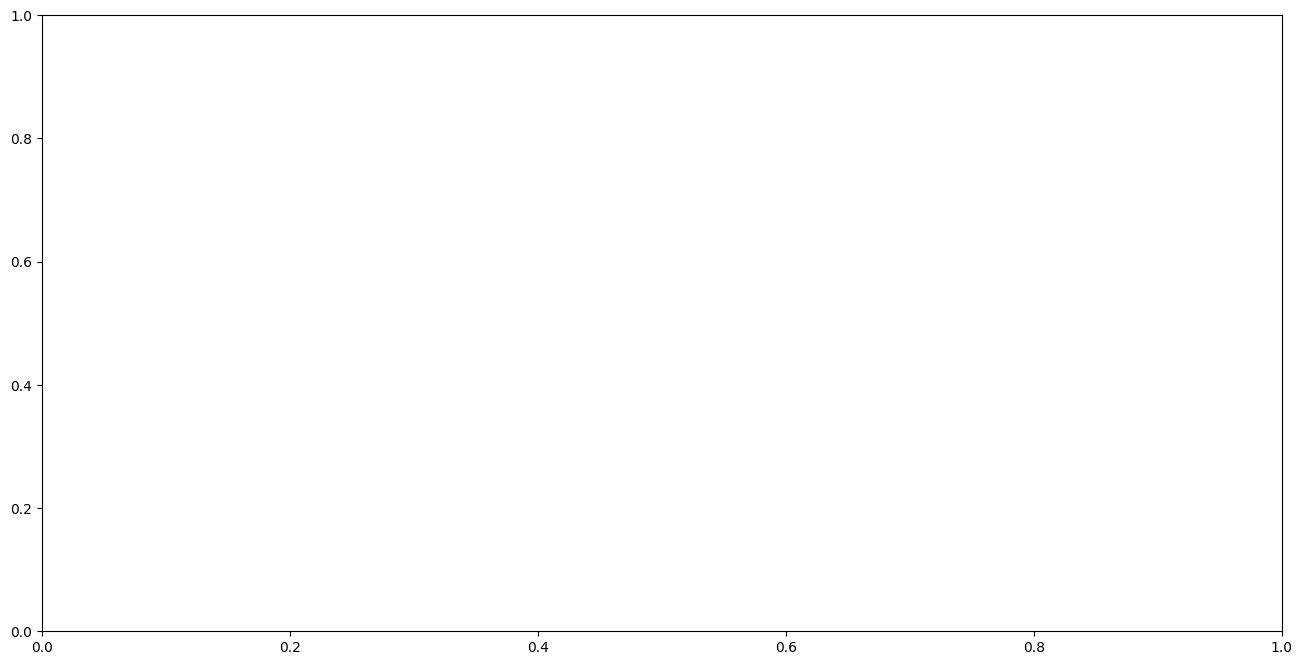

In [65]:
plt.figure(figsize=(16,8))
plt.plot(x_test, color = 'black', label = 'Test')
plt.plot(predicted_prices, color = 'green', label = 'pred')
plt.legend()
plt.show()